In [1]:
# Импортируем библиотеки
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

# Ансамблирование: бустинг

> **Бустинг (boosting)** — это алгоритм построения ансамбля, основанный на последовательном построении слабых моделей, причём каждая новая модель пытается уменьшить ошибку предыдущей. После того как все модели обучены, они объединяются в композицию.

> **Примечание**. Под слабыми моделями мы подразумеваем модели, точность которых немногим выше, чем случайное угадывание. Как правило, это короткие деревья решений, они обладают слабой предсказательной способностью.

Обратите внимание, что в бустинге базовые модели обучаются последовательно, а не параллельно, как в предыдущих методах, исправляя ошибки своего «предшественника»  и повышая качество всего ансамбля. 

Бустинг основан на вопросе, поднятом исследователями [М. Кернсом](https://en.wikipedia.org/wiki/Michael_Kearns_(computer_scientist)) и [Л. Вэлиантом](https://ru.wikipedia.org/wiki/%D0%92%D1%8D%D0%BB%D0%B8%D0%B0%D0%BD%D1%82,_%D0%9B%D0%B5%D1%81%D0%BB%D0%B8): «Может ли набор слабых обучающих алгоритмов создать сильный обучающий алгоритм?»

> В отличие от бэггинга, бустинг обучается на одном и том же наборе данных, без генерации дополнительных выборок. Однако в процессе обучения меняются так называемые **веса наблюдений**. Если слабая модель допустила ошибку на каких-то примерах, то значимость (вес) этих примеров увеличивается и на них концентрируется следующая за ней модель.

Представить алгоритм бустинга можно следующей схемой:

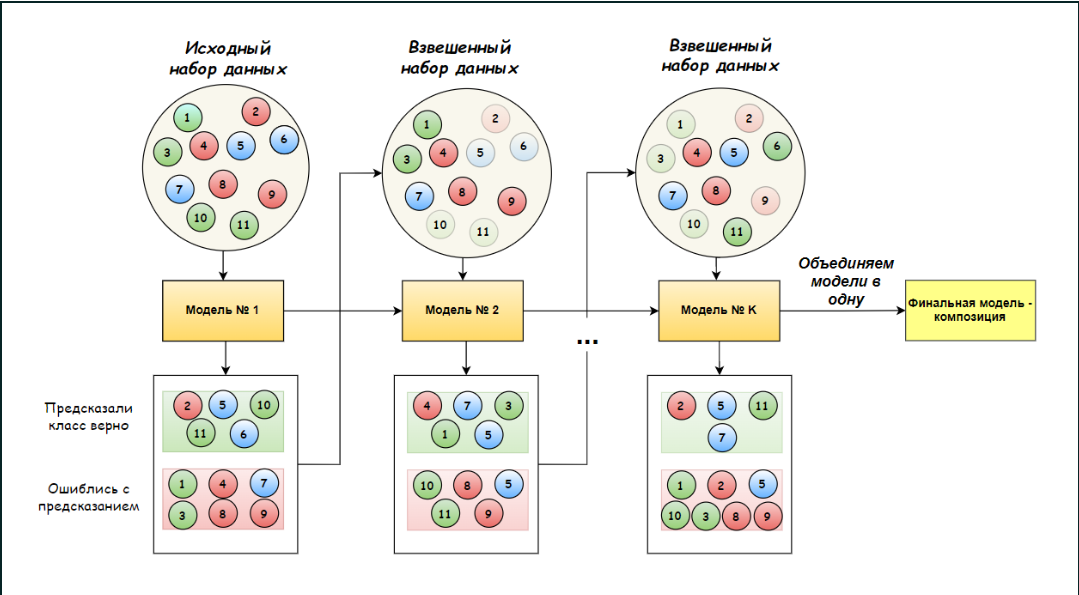

***На схеме  представлено 11 разных наблюдений трёх различных классов (красные, зелёные и синие шарики). После того как модель делает предсказания, мы смотрим, на каких объектах мы угадали класс верно, а на каких ошиблись. Для тех объектов, на которых мы допустили ошибку, мы задаём больший вес. Вес наблюдения обозначается интенсивностью цвета. Чем больше вес наблюдения, тем ярче его цвет.***

> Так же как и бэггинг, бустинг предназначен для обучения моделей одного типа. То есть нельзя последовательно обучить 50 логистических регрессий, а затем 50 деревьев решения.

Каждая модель создаётся для того, чтобы найти ошибки предыдущей. Сами по себе они решают задачу плохо, но стоит объединить их усилия, и мы получим супермодель.

Очень наглядно будет выглядеть модель бустинга для логистической регрессии при обучении на двух признаках:

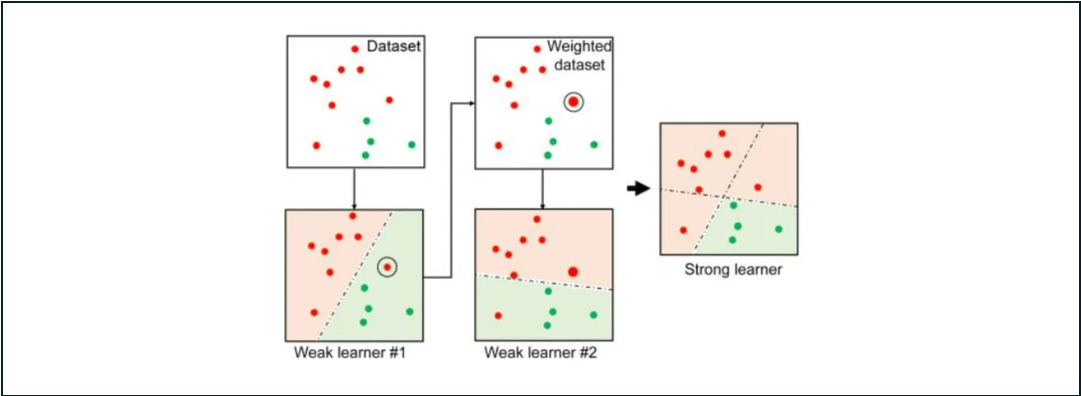

На рисунке изображено расположение двух линейно неразделимых классов. Нельзя провести одну такую плоскость, которая идеально решает задачу классификации. Раз нельзя одну, давайте проведём две.

Возьмём точки, для которых первая логистическая регрессия совершила ошибку. Увеличим вес этих точек (их значимость). Далее построим такую разделяющую плоскость, которая в первую очередь обращает внимание на наблюдения, имеющие наибольший вес.

Наконец, объединим две модели в одну — получим модель-композицию, которая идеально решает задачу классификации!

> **Примечание.** Когда все модели из ансамбля обучены и составлена композиция из них, для того, чтобы совершить предсказание на новом объекте, необходимо «прогнать» характеристики объекта через все модели в той же последовательности, в которой они обучались, и объединить их результат.

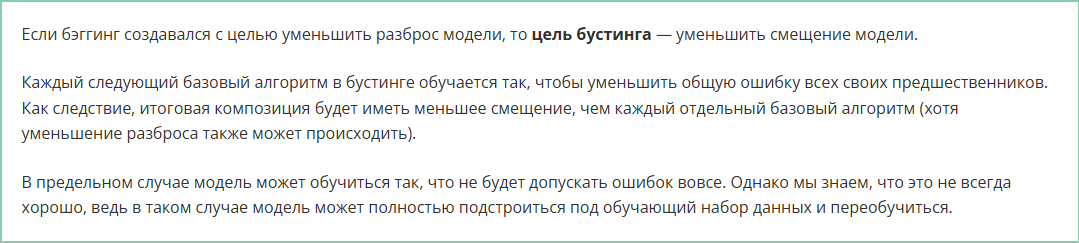

Поскольку основная цель бустинга — уменьшение смещения, в качестве базовых моделей часто выбирают **алгоритмы с высоким смещением и небольшим разбросом**, например короткие деревья решений. У каждого из таких деревьев слабая предсказательная способность, но если их объединить, мы получим очень мощную модель. 

В этом юните мы постараемся затронуть основные шаги эволюции бустинга от первой успешной модели до современных модификаций. Начнём рассмотрение с самой первой модели бустинга — **адаптивного бустинга.**

## АДАПТИВНЫЙ БУСТИНГ 

Первая реализация бустинга называлась **AdaBoost**. Это модель, которая подразумевает воплощение той самой идеи взвешивания объектов, которую мы рассмотрели выше. Алгоритм предполагает постоянную модификацию объектов выборки путём их взвешивания, причём веса обновляются специальным образом: каждая новая модель из ансамбля обучается на взвешенных данных и обращает большее внимание на ошибки своих предшественников.

Так как алгоритм является несовершенным и в дальнейшем получил свое развитие, мы не будем подробно останавливаться на его работе. Однако приведем краткое описание работы алгоритма на примере задачи **бинарной классификации.**

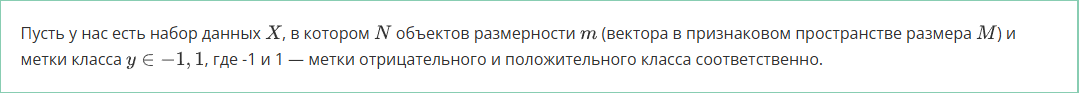

Будем строить ансамбль из ***K*** абстрактных базовых моделей — классификаторов. Обозначим их как ***a(x)*** (это могут быть логистические регрессии/деревья решений или что-то ещё).

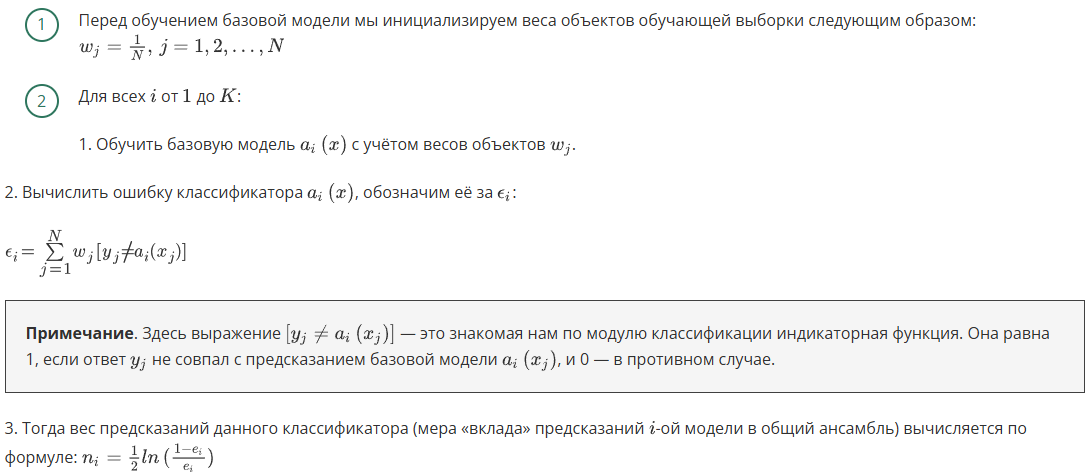

Формула веса становится нулевой только при **случайном угадывании**, то есть когда классификатор ошибается в половине меток — работает ровно так же, как и подбрасывание монетки. Однако остальные будут вносить вес в итоговую модель с положительным или отрицательным знаком (в этом легко убедиться, подставив вероятность ошибки, отличную от 0.5). Тем самым мы исключаем возможность вклада случайных классификаторов в результирующую модель.

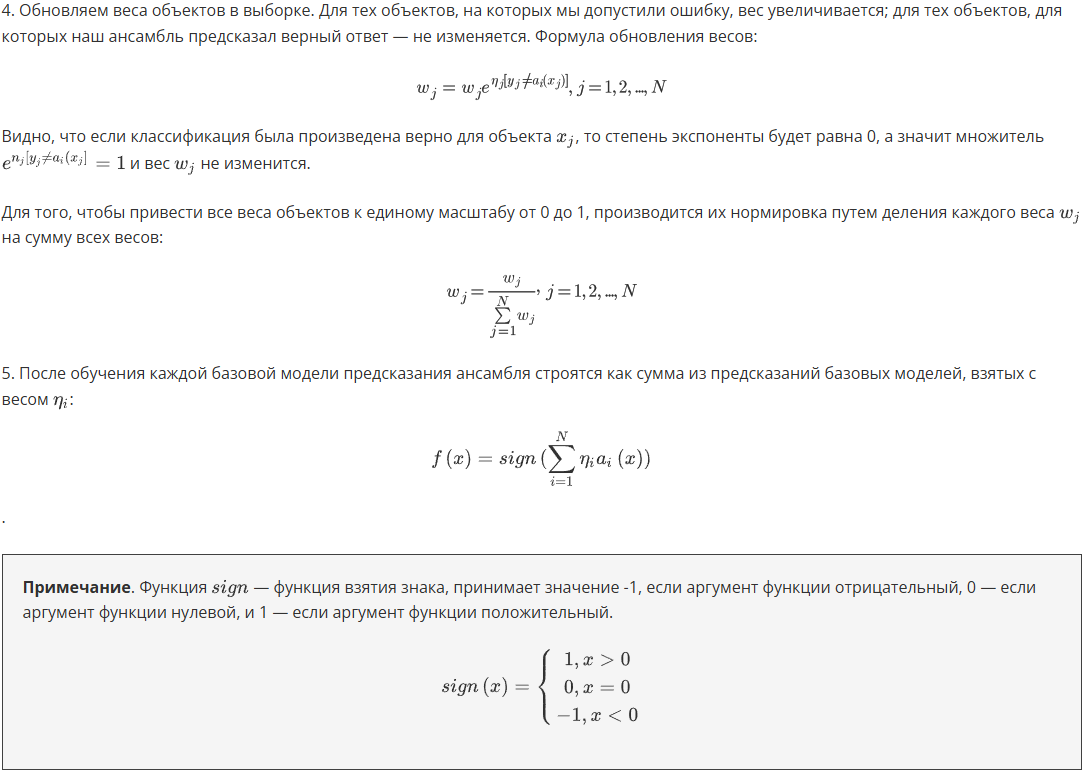

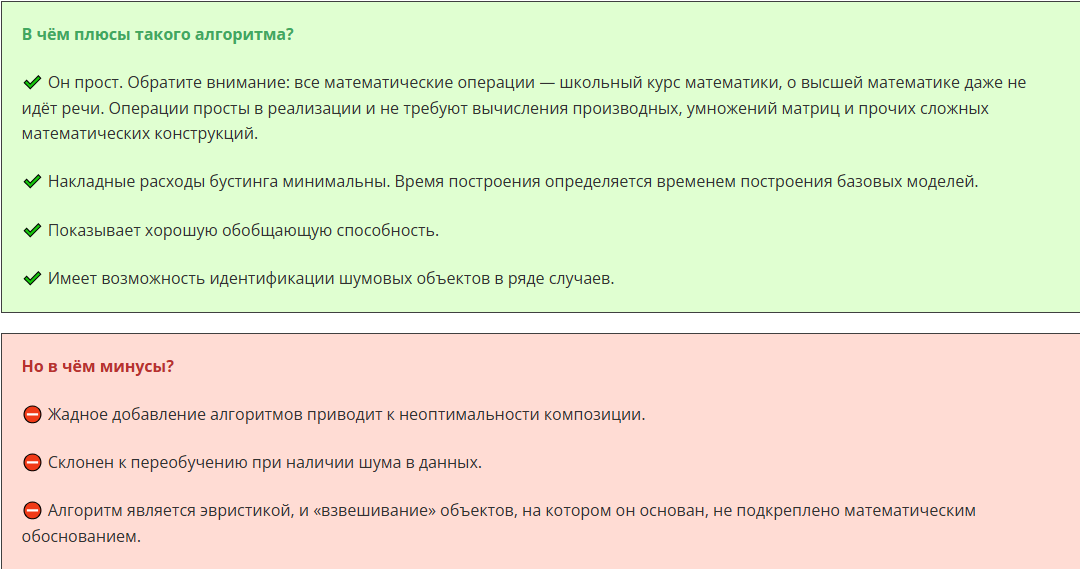

## АДАПТИВНЫЙ БУСТИНГ В SKLEARN

В sklearn адаптивный бустинг над решающими деревьями реализован в модуле *sklearn.ensemble* в виде классов [AdaBoostRegressor ](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html)и [AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier) для задач регрессии и классификации соответственно. Давайте проведём обучение на тех же данных, что и в предыдущих моделях ансамблирования — на данных о диабете. 

Прежде чем перейти к практической части, предлагаем ознакомиться с параметрами AdaBoost:

- **estimator** — параметр отвечает за природу базовых моделей, по умолчанию это DecisionTreeRegressor c максимальной глубиной (max_depth) 3.

- **n_estimators** — максимальное количество базовых моделей, по умолчанию равно 50. В случае идеального обучения алгоритм завершается ранее, чем данное значение.

- **learning_rate** — темп обучения, параметр, добавляющий дополнительный множитель весу базовой модели, по умолчанию он равен 1.

- **loss{'linear', 'square', 'exponential'}** — функция ошибки для обновления весов (в теоретической части мы рассматривали экспоненциальную форму обновления весов — 'exponential')

- **random_state** — параметр, фиксирующий случайные процессы в модели.
Для сравнимости результатов со случайным лесом возьмём количество базовых моделей, равное 10. Как говорилось ранее, глубина деревьев должна быть меньше, чем у случайного леса. По умолчанию она равна 3.  

***см. приложение с кодом***

In [2]:
# Загрузим датасет из библиотеки
data = load_diabetes(as_frame=True)
# Создаем матрицу наблюдений
X = data['frame'].drop('target', axis=1)
# Создаем вектор правильных ответов
y = data['target']
 
X.head()

# Разделим выборку на тренировочную и тестовую
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

### Задание 4.1

Измените количество базовых моделей до 50 и 100. В качестве ответа приведите полученные результаты, округленные до второго знака после запятой. Остальные параметры оставьте неизменными.

Качество модели по MSE для 50 базовых моделей:

Качество модели по MSE для 100 базовых моделей:

In [10]:
# Создаем объект класса дерева решений
dt = DecisionTreeRegressor(
    max_depth=3, #максимальная глубина дерева
    random_state=42 #датчик генератора случайных чисел
)
# Создаем объект класса AdaBoost
ada = AdaBoostRegressor(
    estimator=dt, #базовая модель
    n_estimators=50, #количество моделей в ансамбле
    random_state=42 #датчик генератора случайных чисел
)
# Обучаем модель
ada.fit(X_train, y_train)

# Формируем предсказание для тестовой выборки
ada_pred  = ada.predict(X_test)

# Оцениваем качество по метрике MSE
print(f'Качество предсказания по MSE для AdaBoost {round(mean_squared_error(y_test, ada_pred),2)}')

Качество предсказания по MSE для AdaBoost 2991.76


Основное отличие градиентного бустинга от адаптивного заключается в том, что градиентный бустинг строит композицию из своих базовых моделей, подбирая их оптимальным образом на основе принципа градиентных методов оптимизации. Такая модификация позволяет значительно ускорить процесс последовательного построения ансамбля в сравнении с реализации AdaBoost и добиться лучшего качества за счет меньшего количества моделей в ансамбле. 

## ГРАДИЕНТНЫЙ БУСТИНГ

> Градиентный бустинг (Gradient Boosting, GB) — это наиболее обобщённая версия бустинга, закреплённая математическим обоснованием. Впервые алгоритм был опубликован профессором статистики Стэнфордского университета Джеромом Фридманом. Алгоритм оказался очень эффективным и в дальнейшем был множество раз модифицирован — до Extreme Gradient Boosting ([XgBoost](https://xgboost.readthedocs.io/en/stable/)) и других модификаций, таких как [CatBoost](https://catboost.ai/) от Яндекса и [LightGMB](https://lightgbm.readthedocs.io/en/latest/) от Microsoft.

Сейчас градиентный бустинг и его модификации применяются практически везде. Любой запрос на Яндексе, выбор отеля на Booking или сериала на *Netflix* — всё это работает на градиентном бустинге. 

> В GB принцип классического бустинга сохраняется: каждый последующий алгоритм улучшает предыдущий, но, в отличие эвристического «взвешивания» наблюдений, градиентный бустинг использует информацию о функции потерь для построения нового алгоритма.

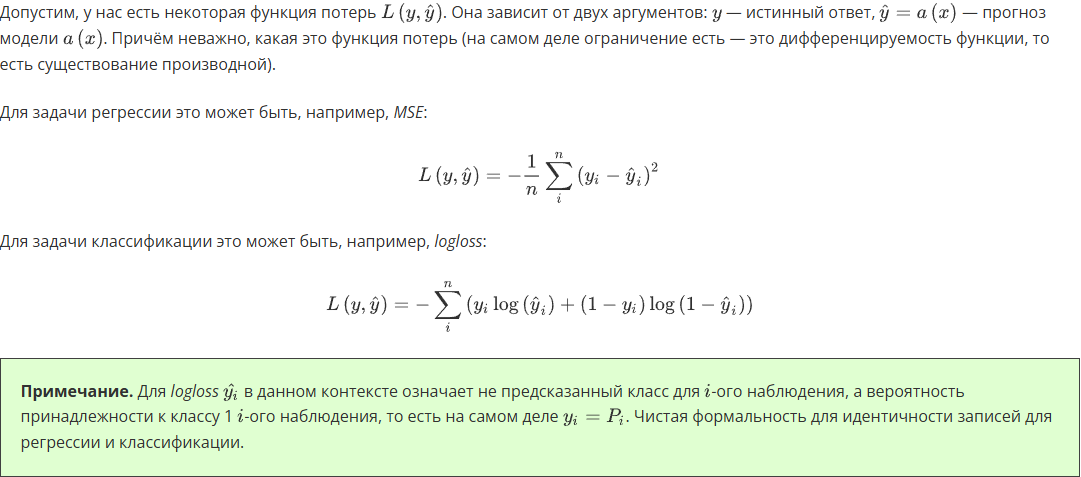

Пусть мы построили какую-то модель, которая решает задачу классификации или регрессии. Обозначим её ***a1(x)*** — это какая-то функция, которая принимает на вход объекты ***x*** и выдаёт для них предсказания. Качество такой модели, скорее всего, будет не очень хорошим, ведь мы обучаем слабые модели.

Однако мы знаем, на каких объектах модель давала точные предсказания, а на каких — ошибалась. Нужно попробовать использовать эту информацию и обучить ещё одну модель ***a2(x)***.

Допустим, мы знаем, что предсказание первой модели на каком-то объекте ***xi*** на 10 больше, чем в реальности. То есть ***a1(xi) = yi + 10*** . То есть нам необходимо обучить следующую модель ***a2(x)*** таким образом, чтобы она предсказала для ***x*** ответ -10, то есть ***a2(xi) = - 10***. Тогда предсказание идеально совпадает с действительностью:

***a1(xi) + a2(xi) = yi + 10 - 10 = yi***

> Другими словами, следующая модель должна научиться предсказывать ошибки предыдущей.

В реальности вторая модель тоже не сможет обучиться идеально, поэтому обучим третью модель ***a3(x)***, которая будет «компенсировать» неточности первых двух. Будем продолжать так, пока не построим композицию из ***K*** алгоритмов.

Финальная модель (обозначим её за ***f(x)***), ищется в виде композиции из ***K*** базовых алгоритмов определённого семейства (например, линейных моделей/деревьев):

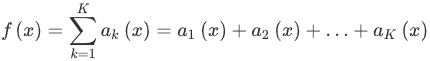

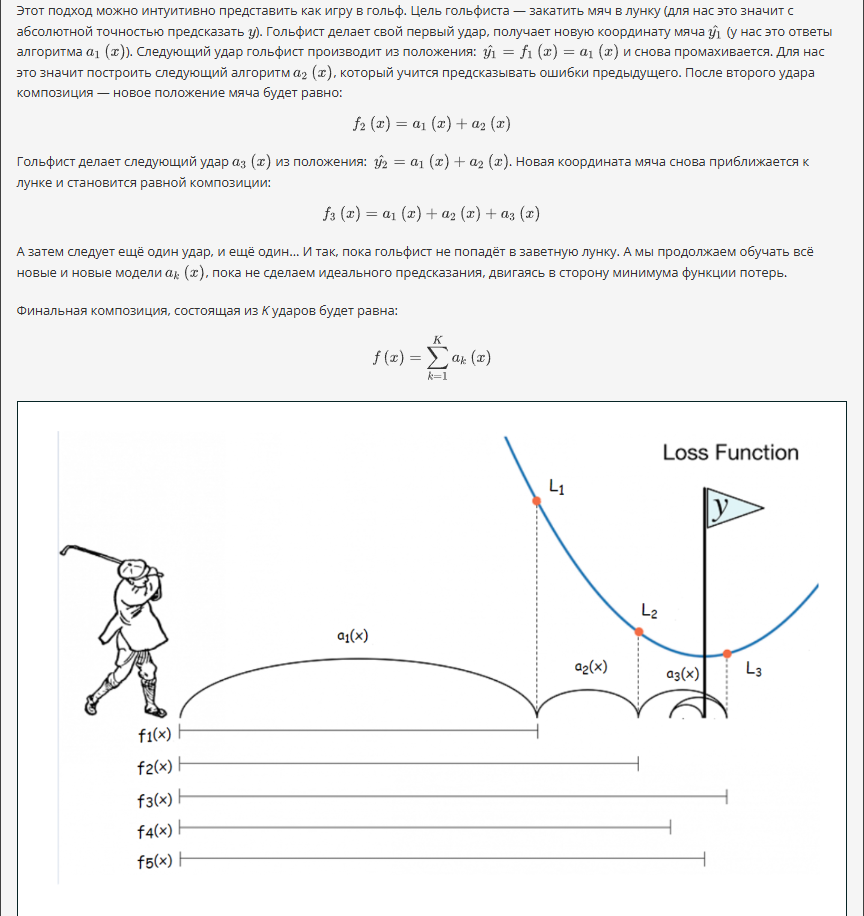

***Немного математического формализма ↓***

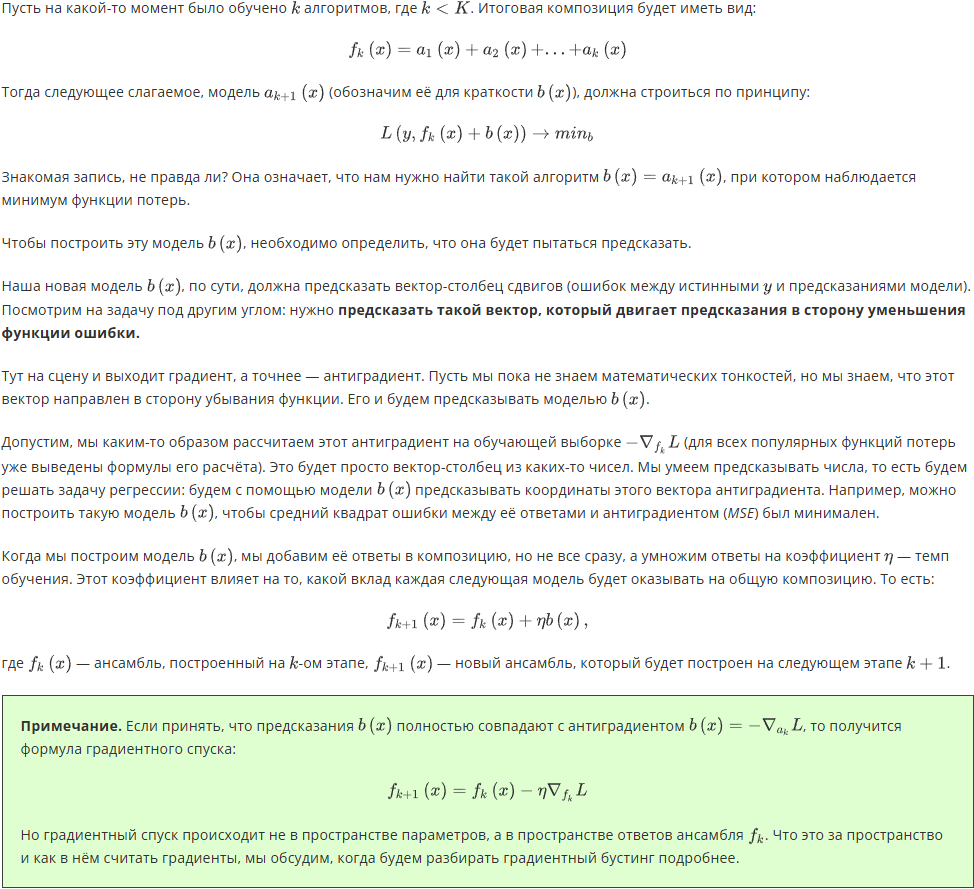

Сейчас же для нас важно понимать, что каждая новая модель бустинга будет строиться так, чтобы двигать всю композицию вниз по функции потерь — в сторону вектора антиградиента.

Зачем нужен параметр **η**?

Он позволяет избежать переобучения и плавно приближаться к минимуму функции потерь.

Например, модель для какого-то i-ого наблюдения ***b(xi)*** предсказала, что ошибка (градиент) будет равна -5. Мы могли бы прибавить к полученным ранее ответам модели ***fk(x)*** эту 5:



Но так мы сразу сведём эту ошибку к 0 и подстроимся под обучающую выборку. Поэтому мы прибавляем не 5, а умножаем 5 на небольшое число **η**, например на 0.1:



Тогда мы будем плавно уменьшать ошибку с каждой новой моделью.

Если базовая модель — это дерево решений, то схематично это будет выглядеть следующим образом:

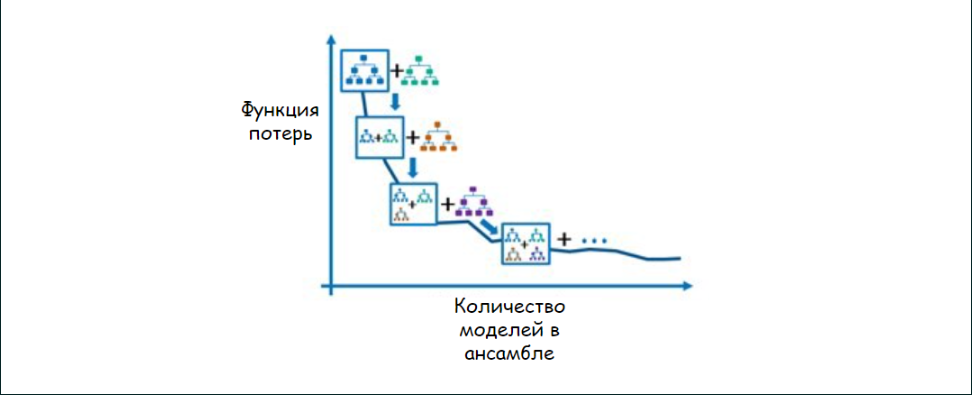

> В качестве базовой модели можно использовать всё что угодно, но общепринятым является использование деревьев решений. Практика показывает, что это наилучший выбор, так как деревья решений очень просты в построении и из всех слабых моделей обладают наилучшей способностью описывать сложные зависимости.

> Бустинг, использующий в качестве базовой модели дерево решений, называется **градиентным бустингом над деревьями решений (Gradient Boosting on Decision Trees, GBDT)**

Схематично работу алгоритма GBDT можно представить следующим образом:

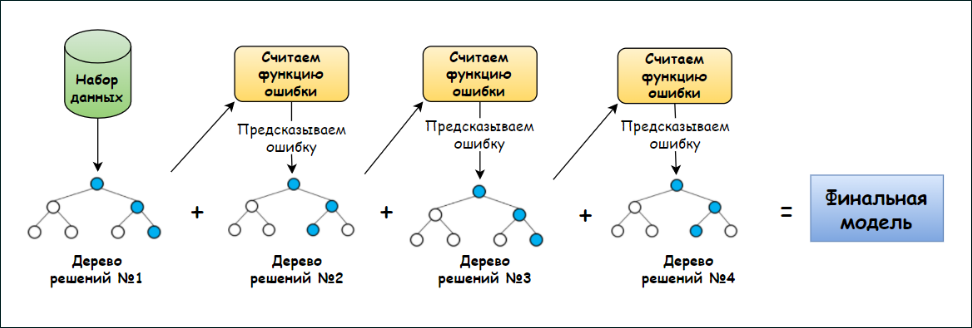

> Основным преимуществом такой схемы градиентного бустинга является эффективность в поиске нелинейных зависимостей в сравнении с любыми моделями, основанными на решающих деревьях. Это преимущество стало причиной доминирования GBDT на огромном спектре соревнований — от кредитного скоринга до рекомендательных систем.

В заключение введения в градиентный бустинг приведём некоторые **рекомендации по выбору внешних параметров алгоритма:**

- **Количество деревьев (n_estimators)**. Чем больше деревьев вы берёте, тем меньше ошибка на обучающем наборе данных, вплоть до 0, но, как вы понимаете, тем выше шанс переобучиться Лучше начинать с небольшого количества моделей (50-100), а затем следить за ошибкой на тестовой выборке.

- **Темп обучения  (learning_rate)**. Чем выше темп обучения, тем больше вклад каждого следующего дерева будет в модель и тем быстрее вы сойдётесь к минимуму функции потерь и сведёте ошибку к 0. Однако снова высок риск переобучения. Рекомендуемые значения — от 0.01 до 1.

- **Максимальная глубина деревьев (max_depth)**. Градиентный бустинг лучше всего работает со слабыми моделями — это короткие деревья решений с глубиной от 1 до 8.

> Все параметры влияют на обучение комплексно, поэтому их следует подбирать одновременно. О том, какие инструменты для этого существуют, мы поговорим в отдельном модуле.

Чтобы понять, как на градиентный бустинг влияют параметры темпа обучения, максимальной глубины деревьев и количества деревьев, предлагаем вам поиграть с настройками градиентного бустинга интерактивной демонстрации [Brilliantly wrong](https://arogozhnikov.github.io/2016/07/05/gradient_boosting_playground.html).

Вы можете регулировать следующие параметры:

- tree depth — максимальная глубина деревьев;

- learning rate — темп обучения;

- subsample — процент выборки, отведённый на обучение;

- trees — количество деревьев.

На демонстрации вы сможете увидеть, как меняется функция ошибки на тренировочной (train loss) и тестовой (test loss) выборках при изменении параметров, а также как меняется вид разделяющей поверхности.

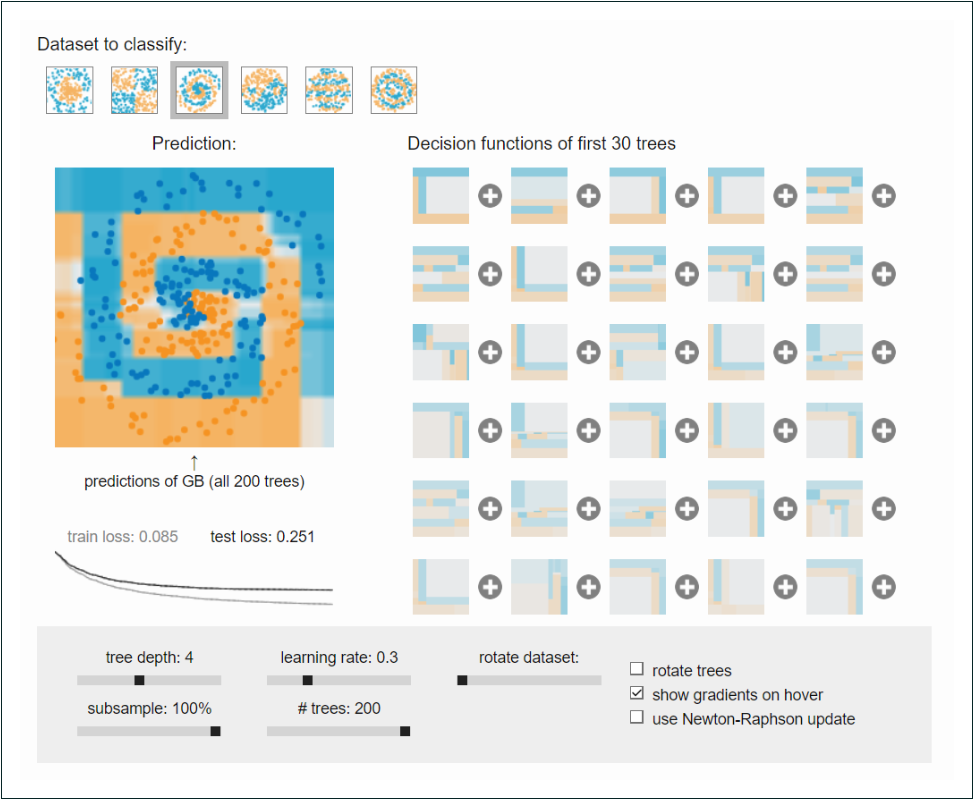

### Задание 4.2

Какие утверждения о бустинге верны?

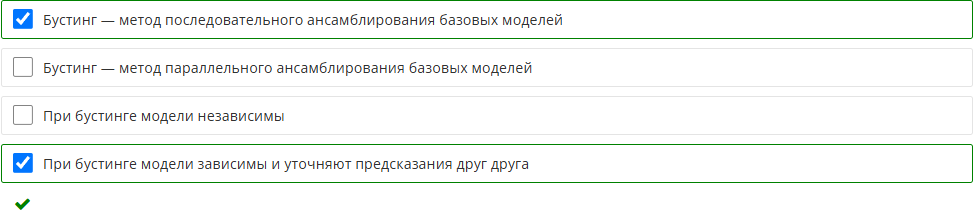

### Задание 4.3

В чём состоит главное преимущество бустинга перед использованием одной базовой модели?

Для ответа на следующий вопрос рекомендуем вам воспользоваться [демонстрацией градиентного бустинга](https://arogozhnikov.github.io/2016/07/05/gradient_boosting_playground.html), приведённой выше.

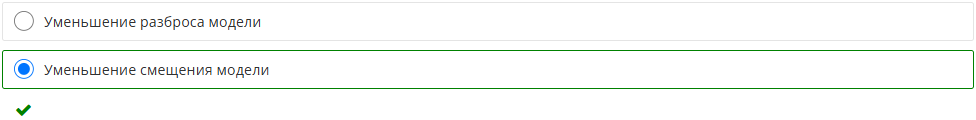

### Задание 4.4

Какое влияние оказывает параметр темпа обучения  (learning rate) в алгоритме градиентного бустинга?

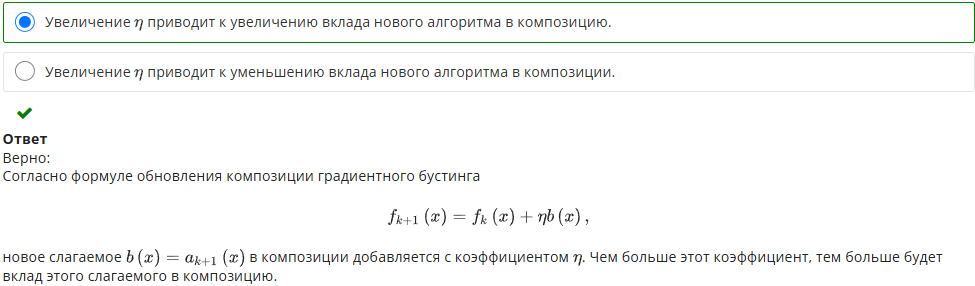

## ГРАДИЕНТНЫЙ БУСТИНГ В SKLEARN

***см. приложение с кодом***

### Задание 4.5

Измените количество базовых моделей с 10 до 50 и 100. В качестве ответа приведите полученные результаты, округленные до второго знака после запятой. Если второе число после запятой равно нулю, округлите до одного знака: например 10.10 необходимо округлить до 10.1. Остальные параметры оставьте неизменными.

Качество модели по MSE для 50 базовых моделей:

Качество модели по MSE для 100 базовых моделей:

In [12]:
# Создаем объект класса градиентный бустинг
gb = GradientBoostingRegressor(
    max_depth=3, #максимальная глубина дерева
    n_estimators=50, #количество деревьев в ансамбле
    random_state=42 #датчик генератора случайных чисел
)

# Обучаем модель
gb.fit(X_train, y_train)

# Формируем предсказание для тестовой выборки
gb_pred  = gb.predict(X_test)

# Оцениваем качество по метрике MSE
print(f'Качество предсказания по MSE для GradientBoostingRegressor {round(mean_squared_error(y_test, gb_pred),2)}')

Качество предсказания по MSE для GradientBoostingRegressor 3100.08


In [14]:
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(random_state=42, n_estimators=100)
gb.fit(X_train, y_train)
 
gb_pred  = gb.predict(X_test)
 
print(f'Качество предсказания по MSE для GradientBoostingRegressor {round(mean_squared_error(y_test, gb_pred),2)}')

Качество предсказания по MSE для GradientBoostingRegressor 3286.02


### Задание 4.6

Обучите на тренировочной выборке (X_train, y_train) модель градиентного бустинга, состоящего из 200 деревьев, максимальная глубина каждого из которых равна 3. Минимальное число объектов в листе — 10. Темп обучения возьмите равный 0.01. Параметр random_state установите в значение 42.


Сделайте предсказание качества вина для тренировочного и тестового набора данных. Рассчитайте метрику accuracy для тестового набора (X_test, y_test) и запишите её в качестве ответа с точностью до двух знаков после запятой.

accuracy на тестовой выборке:

In [22]:
# Читаем исходные данные к задаче классификации
df = pd.read_csv('data/winequality-red.csv', sep = ';')
# Создаем матрицу наблюдений 
X = df.drop(['quality'],axis = 1)
# Создаем вектор признаков для бинарной классификации
y = (df['quality'] >5).astype(int)

# Разделим выборку на тренировочную и тестовую
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [ ]:
# Создаем модель градиентного бустинга
gb = GradientBoostingClassifier(
    loss='log_loss', #функция потерь
    learning_rate=0.01, #темп обучения
    min_samples_leaf = 10, # min число объектов в листе
    n_estimators=200, #число деревьев
    max_depth=3, #максимальная глубина дерева
    random_state=42 #генератор случайных чисел
)
# Обучаем модель
gb.fit(X_train, y_train)
# Формируем предсказание для тестовой выборки
y_pred = gb.predict(X_test)
# Посмотрим на основные метрики классификации
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.74      0.71       238
           1       0.77      0.73      0.75       290

    accuracy                           0.73       528
   macro avg       0.73      0.73      0.73       528
weighted avg       0.73      0.73      0.73       528



### Задание 4.7

Увеличьте количество деревьев до 500, остальные параметры оставьте прежними.


Сделайте предсказание качества вина для тренировочного и тестового набора данных. Рассчитайте метрику accuracy для тестового набора (X_test, y_test) и запишите её в качестве ответа с точностью до двух знаков после запятой.

accuracy на тестовой выборке:

In [ ]:
# Создаем модель градиентного бустинга
gb = GradientBoostingClassifier(
    loss='log_loss', #функция потерь
    learning_rate=0.01, #темп обучения
    min_samples_leaf = 10, # min число объектов в листе
    n_estimators=500, #число деревьев
    max_depth=3, #максимальная глубина дерева
    random_state=42 #генератор случайных чисел
)
# Обучаем модель
gb.fit(X_train, y_train)
# Формируем предсказание для тестовой выборки
y_pred = gb.predict(X_test)
# Посмотрим на основные метрики классификации
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.75      0.73       238
           1       0.79      0.76      0.77       290

    accuracy                           0.75       528
   macro avg       0.75      0.75      0.75       528
weighted avg       0.76      0.75      0.75       528



### Задание 4.8

Увеличьте learning rate до 0.2.


Сделайте предсказание качества вина для тренировочного и тестового набора данных. Рассчитайте метрику accuracy для тестового набора (X_test, y_test) и запишите её в качестве ответа с точностью до двух знаков после запятой.

accuracy на тестовой выборке:

In [ ]:
# Создаем модель градиентного бустинга
gb = GradientBoostingClassifier(
    loss='log_loss', #функция потерь
    learning_rate=0.2, #темп обучения
    min_samples_leaf = 10, # min число объектов в листе
    n_estimators=200, #число деревьев
    max_depth=3, #максимальная глубина дерева
    random_state=42 #генератор случайных чисел
)
# Обучаем модель
gb.fit(X_train, y_train)
# Формируем предсказание для тестовой выборки
y_pred = gb.predict(X_test)
# Посмотрим на основные метрики классификации
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.76      0.77       238
           1       0.81      0.83      0.82       290

    accuracy                           0.80       528
   macro avg       0.80      0.80      0.80       528
weighted avg       0.80      0.80      0.80       528



### Задание 4.9

Как влияет количество моделей ***K*** в алгоритме градиентного бустинга на ошибку на обучающей выборке?

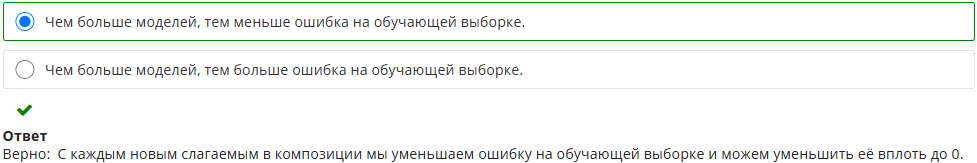

### Задание 4.10

Какими способами можно бороться с переобучением градиентного бустинга над деревьями решений, если их производить независимо друг от друга?

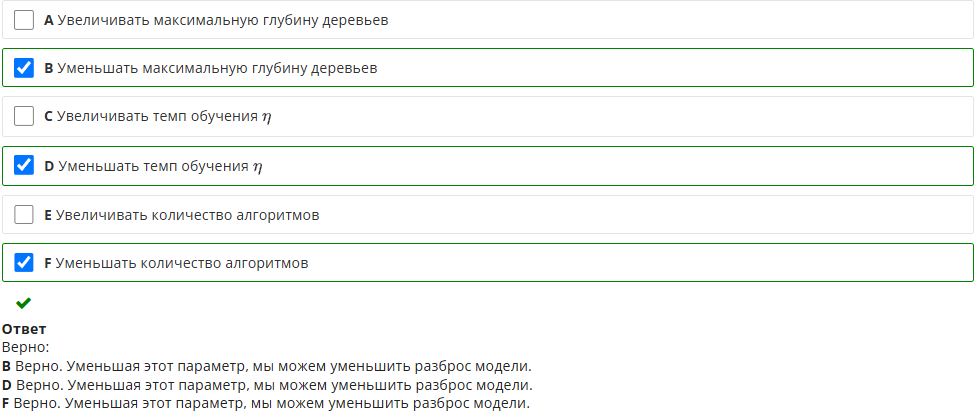

⭐️ Поздравляем! Мы разобрали практически все ныне существующие методы ансамблирования — от самых простых, которые легли в основу случайного леса, до самых передовых (градиентных бустингов). Мы посмотрели на реализации в библиотеке sklearn, постарались разобрать методологию и основные параметры каждой модели. 

Основными рекомендациями по использованию ансамблей является использование случайных лесов и градиентных бустингов в первую очередь для классических задач классификации и регрессии с простыми табличными данными, так как подавляющее большинство соревнований в этой области было выиграно именно благодаря этим двум моделям. 

После данного модуля может сложиться впечатление, что ансамблирование — всегда лучший вариант для финальной модели, однако часто в задачах требуется интерпретируемость результатов, которой не могу похвастаться бустинг и стекинг. 

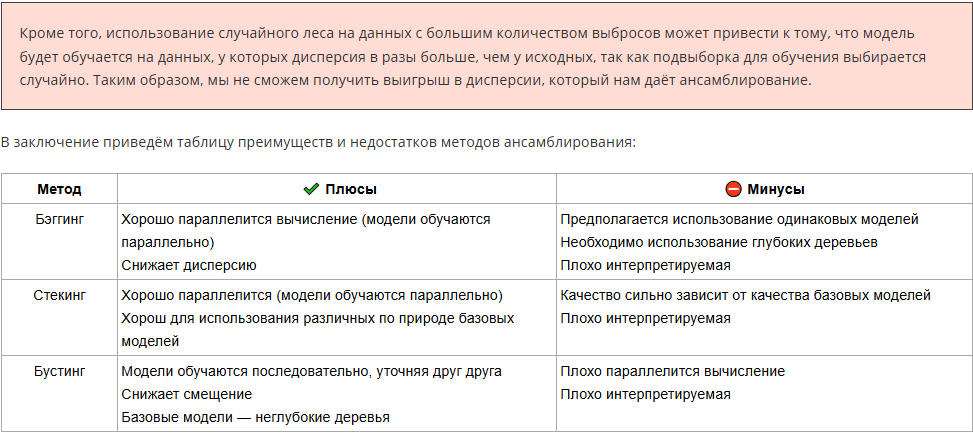

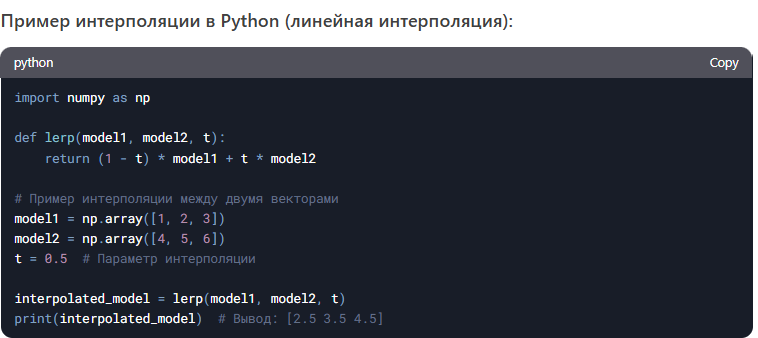